In [1]:
import os
os.chdir('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from ptflops import get_model_complexity_info

from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader
from utils import ModelTrainer
from models.models import BasicLSTM
from utils.datasets import EMGO_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# class EMG_dataset(torch.utils.data.Dataset):
#     def __init__(self, csv, lag, n_ahead):
#         self.csv = csv
#         self.lag = lag
#         self.n_ahead = n_ahead

#     def __len__(self):
#         return len(self.csv) - self.lag - self.n_ahead

#     def __getitem__(self, idx):
#         X = self.csv.iloc[idx:idx+self.lag, :4].values
#         Y = self.csv.iloc[idx+self.lag:idx+self.lag+self.n_ahead, 4:].values
        
#         return (torch.Tensor(X), torch.Tensor(Y))



In [3]:
def train_test_model(model, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=False):
    Trainer = ModelTrainer(model, nn.MSELoss(), torch.optim.Adam(model.parameters(), lr=lr), nn.MSELoss(), "Regression",  device, 0, noPrint=noPrint)
    t0 = datetime.now()
    Trainer.fit(trainLoader, validateLoader, EPOCHS)
    t1 = datetime.now()
    Trainer.Test_Model(testLoader)
    
    if not noPrint:
        print("\nTest Loss:", Trainer.Metrics["Test Loss"], "\nTime to Train:", t1 - t0)
        Trainer.Graph_Metrics()
    
    macs, params = get_model_complexity_info(Trainer.model, (24, 4), as_strings=True, print_per_layer_stat=False, verbose=True)
    Trainer.model.to("cpu")
    
    return Trainer, (macs, params)

,EMG PATH,FRAMES
0,M:/Datasets/shock_walk/processed/2.0mph.csv,1800
1,M:/Datasets/shock_walk/processed/2.5mph.csv,1800
2,M:/Datasets/shock_walk/processed/3.1mph.csv,1800
3,M:/Datasets/shock_walk/processed/Quiet_Stance_...,1800
4,M:/Datasets/shock_walk/processed/StandStop_2mp...,1800


torch.Size([24, 4]) torch.Size([12, 4])
torch.Size([12, 24, 4]) torch.Size([12, 12, 4])


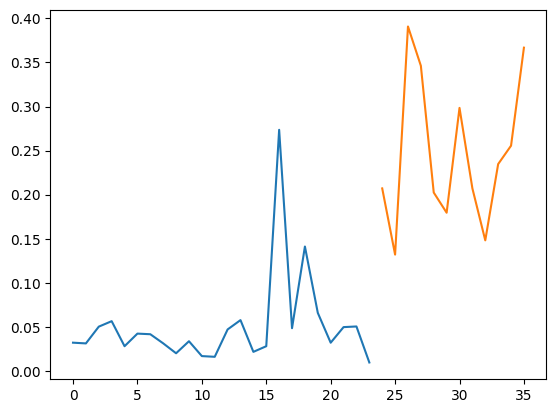

In [4]:
dataset = EMG_dataset("emg.csv", lag=24, n_ahead=12)
X, Y = dataset.__getitem__(0)
print(X.shape, Y.shape)

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2])
trainLoader = DataLoader(train_dataset, batch_size=12, num_workers=0, pin_memory=True, shuffle=False)
validLoader = DataLoader(valid_dataset, batch_size=12, num_workers=0, pin_memory=True, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size=12, num_workers=0, pin_memory=True, shuffle=True)

for X, Y in trainLoader:
    print(X.shape, Y.shape)
    
    # Assume Extension 
    y_range = range(len(X[0]), len(X[0])+validLoader.dataset.dataset.n_ahead)
    
    # First Batch
    plt.plot(X[0][:,0])
    plt.plot(y_range, Y[0][:,0])
    break

In [5]:
def test_parameters(EPOCHS=100, lr=0.001):
    
    dataset = EMG_dataset(total, lag=24, n_ahead=12)

    train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2])
    
    
    input_size = 4
    hidden_sizes = [64, 96, 128]
    num_layers = [3, 4, 5]
    batch_sizes = [2, 3, 4]
    output_size = train_dataset.dataset.n_ahead
    
    results = []
    trainers = []
    
    for hidden_size in hidden_sizes:
        for num_layer in num_layers:
            for batch_size in batch_sizes:
            
                trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
                validLoader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
                testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

                model = BasicLSTM(input_size, hidden_size, num_layer, output_size)

                Trainer, mp = train_test_model(model, lr, trainLoader, validLoader, testLoader, EPOCHS, noPrint=True)
                trainers.append(Trainer)
                
                test_loss = Trainer.Metrics["Test Loss"]
                results.append(f"Hidden: {hidden_size} | Layers: {num_layer} | Batch Size: {batch_size} | Macs: {mp[0]} | Params: {mp[1]} | Test Loss: {test_loss}")
                print(results[-1])
                               
    results = np.array(results)
    
    return results, trainers

In [11]:
re, T = test_parameters(200)

Hidden: 64 | Layers: 3 | Batch Size: 2 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.03852829836886114
Hidden: 64 | Layers: 3 | Batch Size: 3 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05379110254064391
Hidden: 64 | Layers: 3 | Batch Size: 4 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05771690192684699
Hidden: 64 | Layers: 4 | Batch Size: 2 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.027474510929429194
Hidden: 64 | Layers: 4 | Batch Size: 3 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.0301073888780447
Hidden: 64 | Layers: 4 | Batch Size: 4 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.03353911740810014
Hidden: 64 | Layers: 5 | Batch Size: 2 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19420315852047693
Hidden: 64 | Layers: 5 | Batch Size: 3 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19426139073155602
Hidden: 64 | Layers: 5 | Batch Size: 4 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.027084436435043144
Hidden: 96 | Layers: 3 | Ba

Hidden: 64 | Layers: 2 | Batch Size: 4 | Macs: 1.26 MMac | Params: 54.32 k | Test Loss: 0.06733934581279755
Hidden: 64 | Layers: 2 | Batch Size: 16 | Macs: 1.26 MMac | Params: 54.32 k | Test Loss: 0.0748613253235817
Hidden: 64 | Layers: 2 | Batch Size: 32 | Macs: 1.26 MMac | Params: 54.32 k | Test Loss: 0.08276855945587158
Hidden: 64 | Layers: 4 | Batch Size: 4 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.05407020077109337
Hidden: 64 | Layers: 4 | Batch Size: 16 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.0663127526640892
Hidden: 64 | Layers: 4 | Batch Size: 32 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.07040233165025711
Hidden: 64 | Layers: 6 | Batch Size: 4 | Macs: 4.52 MMac | Params: 187.44 k | Test Loss: 0.07566986978054047
Hidden: 64 | Layers: 6 | Batch Size: 16 | Macs: 4.52 MMac | Params: 187.44 k | Test Loss: 0.19122886657714844
Hidden: 64 | Layers: 6 | Batch Size: 32 | Macs: 4.52 MMac | Params: 187.44 k | Test Loss: 0.06731513887643814
Hidden: 128 | Layers: 2 | Batch Size: 4 | Macs: 4.88 MMac | Params: 206.9 k | Test Loss: 0.04985114932060242
Hidden: 128 | Layers: 2 | Batch Size: 16 | Macs: 4.88 MMac | Params: 206.9 k | Test Loss: 0.05833622068166733
Hidden: 128 | Layers: 2 | Batch Size: 32 | Macs: 4.88 MMac | Params: 206.9 k | Test Loss: 0.06787940114736557
Hidden: 128 | Layers: 4 | Batch Size: 4 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.02661198005080223
Hidden: 128 | Layers: 4 | Batch Size: 16 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.04889538139104843
Hidden: 128 | Layers: 4 | Batch Size: 32 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.05771384760737419
Hidden: 128 | Layers: 6 | Batch Size: 4 | Macs: 17.69 MMac | Params: 735.28 k | Test Loss: 0.19148249924182892
Hidden: 128 | Layers: 6 | Batch Size: 16 | Macs: 17.69 MMac | Params: 735.28 k | Test Loss: 0.19151681661605835
Hidden: 128 | Layers: 6 | Batch Size: 32 | Macs: 17.69 MMac | Params: 735.28 k | Test Loss: 0.05349093675613403
Hidden: 256 | Layers: 2 | Batch Size: 4 | Macs: 19.21 MMac | Params: 806.96 k | Test Loss: 0.024070965126156807
Hidden: 256 | Layers: 2 | Batch Size: 16 | Macs: 19.21 MMac | Params: 806.96 k | Test Loss: 0.046882450580596924
Hidden: 256 | Layers: 2 | Batch Size: 32 | Macs: 19.21 MMac | Params: 806.96 k | Test Loss: 0.05703727528452873
Hidden: 256 | Layers: 4 | Batch Size: 4 | Macs: 44.59 MMac | Params: 1.86 M | Test Loss: 0.014045578427612782
Hidden: 256 | Layers: 4 | Batch Size: 16 | Macs: 44.59 MMac | Params: 1.86 M | Test Loss: 0.03199911490082741
Hidden: 256 | Layers: 4 | Batch Size: 32 | Macs: 44.59 MMac | Params: 1.86 M | Test Loss: 0.05679785832762718
Hidden: 256 | Layers: 6 | Batch Size: 4 | Macs: 69.98 MMac | Params: 2.91 M | Test Loss: 0.01443294994533062
Hidden: 256 | Layers: 6 | Batch Size: 16 | Macs: 69.98 MMac | Params: 2.91 M | Test Loss: 0.19122442603111267
Hidden: 256 | Layers: 6 | Batch Size: 32 | Macs: 69.98 MMac | Params: 2.91 M | Test Loss: 0.04160312935709953


Hidden: 64 | Layers: 3 | Batch Size: 2 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.03852829836886114 -------------- 22
Hidden: 64 | Layers: 3 | Batch Size: 3 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05379110254064391
Hidden: 64 | Layers: 3 | Batch Size: 4 | Macs: 2.08 MMac | Params: 87.6 k | Test Loss: 0.05771690192684699
Hidden: 64 | Layers: 4 | Batch Size: 2 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.027474510929429194 ----------- 44 
Hidden: 64 | Layers: 4 | Batch Size: 3 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.0301073888780447
Hidden: 64 | Layers: 4 | Batch Size: 4 | Macs: 2.89 MMac | Params: 120.88 k | Test Loss: 0.03353911740810014
Hidden: 64 | Layers: 5 | Batch Size: 2 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19420315852047693 
Hidden: 64 | Layers: 5 | Batch Size: 3 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.19426139073155602
Hidden: 64 | Layers: 5 | Batch Size: 4 | Macs: 3.7 MMac | Params: 154.16 k | Test Loss: 0.027084436435043144
Hidden: 96 | Layers: 3 | Batch Size: 2 | Macs: 4.59 MMac | Params: 192.82 k | Test Loss: 0.018354135989145915 ----------- 105 params/loss
Hidden: 96 | Layers: 3 | Batch Size: 3 | Macs: 4.59 MMac | Params: 192.82 k | Test Loss: 0.023365079570671677
Hidden: 96 | Layers: 3 | Batch Size: 4 | Macs: 4.59 MMac | Params: 192.82 k | Test Loss: 0.02599003931423754
Hidden: 96 | Layers: 4 | Batch Size: 2 | Macs: 6.4 MMac | Params: 267.31 k | Test Loss: 0.02259094557055915 
Hidden: 96 | Layers: 4 | Batch Size: 3 | Macs: 6.4 MMac | Params: 267.31 k | Test Loss: 0.015441903353271856 ------------ 178
Hidden: 96 | Layers: 4 | Batch Size: 4 | Macs: 6.4 MMac | Params: 267.31 k | Test Loss: 0.015215227144948218
Hidden: 96 | Layers: 5 | Batch Size: 2 | Macs: 8.21 MMac | Params: 341.81 k | Test Loss: 0.028138752559750853
Hidden: 96 | Layers: 5 | Batch Size: 3 | Macs: 8.21 MMac | Params: 341.81 k | Test Loss: 0.01905760160580529
Hidden: 96 | Layers: 5 | Batch Size: 4 | Macs: 8.21 MMac | Params: 341.81 k | Test Loss: 0.016250657833317358
Hidden: 128 | Layers: 3 | Batch Size: 2 | Macs: 8.09 MMac | Params: 338.99 k | Test Loss: 0.01571980871548745
Hidden: 128 | Layers: 3 | Batch Size: 3 | Macs: 8.09 MMac | Params: 338.99 k | Test Loss: 0.014225505634293527 ----------- 238
Hidden: 128 | Layers: 3 | Batch Size: 4 | Macs: 8.09 MMac | Params: 338.99 k | Test Loss: 0.01518362178990429
Hidden: 128 | Layers: 4 | Batch Size: 2 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.011967644840478898
Hidden: 128 | Layers: 4 | Batch Size: 3 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.013977898239602143
Hidden: 128 | Layers: 4 | Batch Size: 4 | Macs: 11.29 MMac | Params: 471.09 k | Test Loss: 0.01380843789253928
Hidden: 128 | Layers: 5 | Batch Size: 2 | Macs: 14.49 MMac | Params: 603.18 k | Test Loss: 0.014370669010029712
Hidden: 128 | Layers: 5 | Batch Size: 3 | Macs: 14.49 MMac | Params: 603.18 k | Test Loss: 0.01119589042665146 ------------- 543
Hidden: 128 | Layers: 5 | Batch Size: 4 | Macs: 14.49 MMac | Params: 603.18 k | Test Loss: 0.012140138077371743


In [6]:
input_size = 4
hidden_size = 128
num_layers = 5
batch_size = 3
output_size = train_dataset.dataset.n_ahead

trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validLoader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = BasicLSTM(input_size, hidden_size, num_layers, output_size)

Trainer, mp = train_test_model(model, 0.001, trainLoader, validLoader, testLoader, EPOCHS=300, noPrint=False)
print(mp)

100%|██████████████████████████████████████████████████████████████████████████████| 2058/2058 [01:20<00:00, 25.52it/s]


EPOCH: 1
Training Loss: 0.028921856110475676  | Validation Loss: 0.02244462428965327


100%|██████████████████████████████████████████████████████████████████████████████| 2058/2058 [01:20<00:00, 25.60it/s]


EPOCH: 2
Training Loss: 0.022728485626426948  | Validation Loss: 0.021306263707771417


100%|██████████████████████████████████████████████████████████████████████████████| 2058/2058 [01:20<00:00, 25.67it/s]


EPOCH: 3
Training Loss: 0.02169600339642381  | Validation Loss: 0.020795273433398254


100%|██████████████████████████████████████████████████████████████████████████████| 2058/2058 [01:21<00:00, 25.35it/s]


EPOCH: 4
Training Loss: 0.02112617444195418  | Validation Loss: 0.02041275412173701


100%|██████████████████████████████████████████████████████████████████████████████| 2058/2058 [01:20<00:00, 25.63it/s]


EPOCH: 5
Training Loss: 0.020742465037670604  | Validation Loss: 0.020009578377100302


 63%|█████████████████████████████████████████████████▍                            | 1306/2058 [00:51<00:29, 25.52it/s]

KeyboardInterrupt



(12,) torch.Size([3, 12, 4]) torch.Size([24, 4])


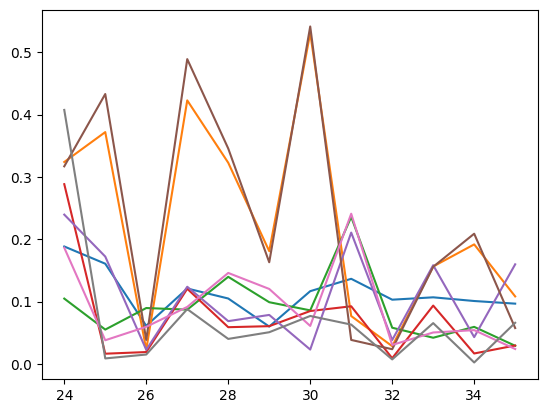

In [27]:
model_path = "./models/pre-trained/EMG_P1.pt"
model = BasicLSTM(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load(model_path))

for X, Y in testLoader:
    X = X
    Y = Y
    pred = Trainer.model(X).detach().numpy()
    
    print(pred[0,:,0].shape, Y.shape, X[0].shape)
    
    # Assume Extension 
    y_range = range(len(X[0]), len(X[0])+validLoader.dataset.dataset.n_ahead)

    
    # plt.plot(X[0,:].detach().cpu())
    plt.plot(y_range, pred[0,:])
    
    plt.plot(y_range, Y[0,:])
    
    # plt.legend(["X", "Prediction", "Actual"])
    
    break

In [13]:
for x, y in trainLoader:
    print(x.shape, y.shape)
    break


torch.Size([3, 24, 4]) torch.Size([3, 12, 3])


In [11]:
len(testLoader)

60

In [9]:
max((total.values).reshape(-1))

3.962974854046147

In [18]:
torch.save(Trainer.model.state_dict(), "models/EMG_Last.pt")